### [리조트 호텔 취소 예측 모델 만들기]
- 고객의 정보를 입력하고 그 고객이 취소를 할 퍼센트는 얼마나 되는지 확인.  
- 타겟 : is_canceled
- 피처 : 상관계수 0.1 넘는 수치형 데이터.
- 모델 : 예측(회귀)

[1] 모듈 및 데이터 불러오기 <hr>

In [2]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 불러오기
file = '../data/hotel_bookings.csv'
htDF = pd.read_csv(file)


[2] 데이터 전처리 <hr>

In [3]:
#htDF.info()
# 호텔의 값 중에 Resort Hotel만 분리.
rtDF = htDF[htDF['hotel']=='Resort Hotel']
#rtDF.columns

In [5]:
rtDF.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,31851.000000,3108.000000,40060.000000,40060.000000,40060.000000,40060.00000
mean,0.277634,92.675686,2016.121443,27.140864,15.821243,1.189815,3.128732,1.867149,0.128682,0.013904,0.044383,0.101722,0.146455,0.287968,217.571725,241.486165,0.527758,94.952930,0.138068,0.61977
std,0.447837,97.285315,0.722347,14.005441,8.883708,1.147812,2.461329,0.697285,0.445195,0.118998,0.205948,1.335115,1.001955,0.726548,88.264489,125.930668,7.428580,61.442418,0.351001,0.81393
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.00000
25%,0.000000,10.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,240.000000,154.000000,0.000000,50.000000,0.000000,0.00000
50%,0.000000,57.000000,2016.000000,28.000000,16.000000,1.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,240.000000,223.000000,0.000000,75.000000,0.000000,0.00000
75%,1.000000,155.000000,2017.000000,38.000000,24.000000,2.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,242.000000,330.000000,0.000000,125.000000,0.000000,1.00000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,2.000000,1.000000,26.000000,30.000000,17.000000,535.000000,543.000000,185.000000,508.000000,8.000000,5.00000


<컬럼 정보>

- is_canceled : 예약이 취소되었는지 여부 (1: 취소, 0: 취소되지 않음) = 결측치 없음(Mean 0.37,  Std. Deviation 0.48)

- lead_time : 예약이 이루어진 날짜와 체크인 날짜 간의 기간 (일) = 결측치 없음(Mean104 Std. Deviation 107)

- 도착년도 arrival_date_year : 도착한 연도 = (Mean 2.02k,    Std. Deviation 0.71)


- 도착 월 arrival_date_month : 도착한 월 = August 12%   July 11% Other (92852) 78%

- 도착 주 (ex - 27주차) arrival_date_week_number : 도착한 주 (연중 주 단위) = (Mean 27.2   Std. Deviation 13.6 )

- 도착 일 arrival_date_day_of_month : 도착한 날짜 = (Mean 15.8   Std. Deviation 8.78) = (+ 도착년도+ 월+ 일 다 붙여서(아마 str로 변경해서) 날짜 데이터로 변경 가능할듯.)

- 주말 숙박 stays_in_weekend_nights : 주말에 머무른 밤 수 = (Mean 0.93    Std. Deviation 1)

- 평일 숙박 stays_in_week_nights : 주중에 머무른 밤 수 = (Mean 2.5  Std. Deviation 1.91)

- 성인 adults : Number of adults = (Mean 1.86 Std. Deviation 0.58)

- 아이 children : Number of children = Mismatched 4 (Mean0.1     Std. Deviation0.4)

- 아기 babies : Number of babies =(Mean 0.01  Std. Deviation 0.1)

- 예약한 식사 meal : Type of meal booked. Categories are presented in standard hospitality meal packages: ===> 수치 데이터로 변경.
- 식사 예약 안함 = Undefined/SC – no meal package; 
- 숙박과 아침식사 = BB – Bed & Breakfast; 
- 아침식사와 그외 식사한끼(보통 저녁)HB – Half board (breakfast and one other meal – usually dinner); 
- 아침+점심+저녁 = FB – Full board (breakfast, lunch and dinner)
- (Unique 5)

- 출신국가 country : Country of origin. Categories are represented in the ISO 3155–3:2013 format (Unique 178)

- 시장 부문 market_segment : Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”
+ TA : Travel Agents= a person whose job is to help people who want to travel by buying plane tickets, making hotel reservations, etc.
+ TO : 여행사? Tour Operators = a company that makes arrangements for travel and places to stay

- 유통 경로 distribution_channel : Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”
+ TA : Travel Agents
+ TO : Tour Operators

- is_repeated_guest 이전에 방문한 적 있는 고객 : Value indicating if the booking name was from a repeated guest (1) or not (0)

- 이전 예약 취소 건수 previous_cancellations : 고객이 현재 예약 전에 취소한 이전 예약 수 Number of previous bookings that were cancelled by the customer prior to the current booking
- (Mean 0.09   Std. Deviation 0.84)

- 이전 예약이 취소되지 않았음. previous_bookings_not_canceled : 고객이 현재 예약 전에 이전 예약을 취소하지 않았음. Number of previous bookings not cancelled by the customer prior to the current booking
- (Mean 0.14   Std. Deviation 1.5)

- 예약된 객실 유형 reserved_room_type : Code of room type reserved. : (익명성을 이유로 코드로 제시.) Code is presented instead of designation for anonymity reasons.

- 제공된 방 유형 assigned_room_type : Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons.
	- 예약에 할당된 객실 유형

- 예약 변경 booking_changes : Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
- (+PMS : Project management system)

- deposit_type : Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay.
- 보증금 유형 : 보증금 없음 - 환불 불가 - 환불 가능

- agent : ID of the travel agency that made the booking
- 에이전트 : 예약한 여행사 아이디
- (=> Null 값이 14% )

- company : ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons
	예약을 한 업체/단체 아이디. 익명성을 이유로 아이디 제시. => 결측치가 너무 많아서 삭제.
- (=> Null 값이 94%기 때문에 )

- days_in_waiting_list : Number of days the booking was in the waiting list before it was confirmed to the customer
- 대기일수 : 예약이 고객에게 확인되기 전 일수 

- customer_type : Type of booking, assuming one of four categories: Contract - when the booking has an allotment or other type of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking
- 고객 유형 : 

- adr : Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
	: 일평균 숙박요금(숙박비의 총합을 숙박일수로 나눈 값)

- required_car_parking_spaces : Number of car parking spaces required by the customer
- 주차장 공간 : 고객이 필요한 주차장 공간

- total_of_special_requests : Number of special requests made by the customer (e.g. twin bed or high floor)
	- 총 추가 요청사항 개수 : 투숙객 추가 요청사항 

- reservation_status : Reservation last status, assuming one of three categories: 
- Canceled – booking was canceled by the customer; 
- Check-Out – customer has checked in but already departed;
- No-Show – customer did not check-in and did inform the hotel of the reason why
- 예약 현황 : 취소 / 체크아웃/ no show

- reservation_status_date : Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking - - - canceled or when did the customer checked-out of the hotel
- 예약 현황 날짜 : 마지막 상태를 설정한 날짜. 예약 현황과 함께 취소일 혹은 체크아웃 날짜를 파악할 수 있음.

In [5]:
# 날짜 데이터 
rtDF['arrival_date_month'].unique()

# 월 데이터 형 변환.
rtDF['arrival_date_month'] = rtDF['arrival_date_month'].replace({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,
                                                                  'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}).astype(int)

C:\Users\KDP-48\AppData\Local\Temp\ipykernel_20248\495130867.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtDF['arrival_date_month'] = rtDF['arrival_date_month'].replace({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,


In [6]:
#rtDF['arrival_date_month'].info()

In [7]:
#rtDF['deposit_type'].unique()
# 보증금 No Deposit => 0, refundable => 1, Non Refund => 2
rtDF['deposit_type'].unique()
rtDF['deposit_type'] = rtDF['deposit_type'].replace({'No Deposit':0, 'Refundable':1, 'Non Refund':2})
#rtDF['deposit_type'].info()

C:\Users\KDP-48\AppData\Local\Temp\ipykernel_20248\2782483399.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtDF['deposit_type'] = rtDF['deposit_type'].replace({'No Deposit':0, 'Refundable':1, 'Non Refund':2})


In [8]:
# 예약 상태의 값 중 Check-Out을 0, Canceled/No-show을 1로 변경.
#rtDF['reservation_status'].unique()
rtDF['reservation_status'] = rtDF['reservation_status'].replace({'Check-Out':0, 'Canceled':1, 'No-Show':1})

C:\Users\KDP-48\AppData\Local\Temp\ipykernel_20248\3267963912.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtDF['reservation_status'] = rtDF['reservation_status'].replace({'Check-Out':0, 'Canceled':1, 'No-Show':1})


In [9]:
#A-E로 구성된 assigned_room_type을 수치데이터로 변경.

len(rtDF['assigned_room_type'].unique())

from sklearn.preprocessing import LabelEncoder
lblEncoder = LabelEncoder()

lblEncoder.fit(rtDF['assigned_room_type'])
rtDF['assigned_room_type'] = lblEncoder.transform(rtDF['assigned_room_type'])

lblEncoder.fit(rtDF['reserved_room_type'])
rtDF['reserved_room_type'] = lblEncoder.transform(rtDF['reserved_room_type'])

print(rtDF['assigned_room_type'].unique(), rtDF['reserved_room_type'].unique())

[ 2  0  3  4  6  5  8  1  7 10  9] [2 0 3 4 6 5 7 8 9 1]


C:\Users\KDP-48\AppData\Local\Temp\ipykernel_20248\3763201844.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtDF['assigned_room_type'] = lblEncoder.transform(rtDF['assigned_room_type'])
C:\Users\KDP-48\AppData\Local\Temp\ipykernel_20248\3763201844.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtDF['reserved_room_type'] = lblEncoder.transform(rtDF['reserved_room_type'])


In [10]:
rtcorr = abs(rtDF.corr(numeric_only=True))
rtcorr['is_canceled'].sort_values(ascending=False)

# => is canceled를 기준으로 상관계수를 도출해 보았더니 reservation_status 컬럼과 is_canceled가 완전히 같아져서 reservation status를 삭제하기로 결정.
# => 또한 결측값이 많은 company 컬럼을 삭제.

rtDF = rtDF.drop('reservation_status', axis=1)
rtDF = rtDF.drop('company', axis=1)
rtDF = rtDF.drop('agent', axis=1)
rtDF.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status_date'],
      dtype='object')

In [11]:
abs(rtDF.corr(numeric_only=True)).sort_values(by='is_canceled', ascending=False)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,1.000000,0.229444,0.043624,0.025185,0.021601,0.009386,0.078569,0.078477,0.080546,0.081234,...,0.114173,0.076767,0.026966,0.111855,0.114835,0.317359,0.036301,0.109317,0.243863,0.101295
deposit_type,0.317359,0.202301,0.070719,0.014569,0.014063,0.003100,0.023005,0.026833,0.001191,0.060978,...,0.231728,0.031519,0.122415,0.165410,0.067298,1.000000,0.000817,0.101550,0.082317,0.164994
required_car_parking_spaces,0.243863,0.151192,0.011293,0.005897,0.007667,0.013719,0.091199,0.103011,0.013443,0.046689,...,0.026987,0.044431,0.099643,0.130914,0.062183,0.082317,0.013126,0.096120,1.000000,0.074713
lead_time,0.229444,1.000000,0.059249,0.127096,0.121448,0.024389,0.325712,0.387608,0.136744,0.000640,...,0.093954,0.108303,0.005975,0.105536,0.075317,0.202301,0.089244,0.030482,0.151192,0.007828
booking_changes,0.114835,0.075317,0.036056,0.011072,0.010635,0.004723,0.057392,0.085822,0.010911,0.044494,...,0.026416,0.002486,0.014582,0.054169,1.000000,0.067298,0.015253,0.030811,0.062183,0.029732
previous_cancellations,0.114173,0.093954,0.103922,0.046827,0.043196,0.043768,0.006361,0.006203,0.006338,0.020091,...,1.000000,0.021632,0.052760,0.066915,0.026416,0.231728,0.005393,0.043399,0.026987,0.044578
assigned_room_type,0.111855,0.105536,0.031138,0.014013,0.013021,0.015377,0.004590,0.000809,0.095917,0.309319,...,0.066915,0.009003,0.794609,1.000000,0.054169,0.165410,0.015917,0.248924,0.130914,0.078257
adr,0.109317,0.030482,0.127791,0.160596,0.157066,0.040700,0.103604,0.119572,0.202422,0.355781,...,0.043399,0.083925,0.402914,0.248924,0.030811,0.101550,0.014189,1.000000,0.096120,0.185266
is_repeated_guest,0.103563,0.150050,0.072335,0.079712,0.078302,0.002194,0.119593,0.130398,0.125123,0.043235,...,0.004552,0.427960,0.071378,0.010528,0.001000,0.044729,0.010546,0.106158,0.055085,0.000603
total_of_special_requests,0.101295,0.007828,0.063893,0.047677,0.045231,0.011683,0.062372,0.058476,0.079015,0.028458,...,0.044578,0.015483,0.098724,0.078257,0.029732,0.164994,0.049260,0.185266,0.074713,1.000000


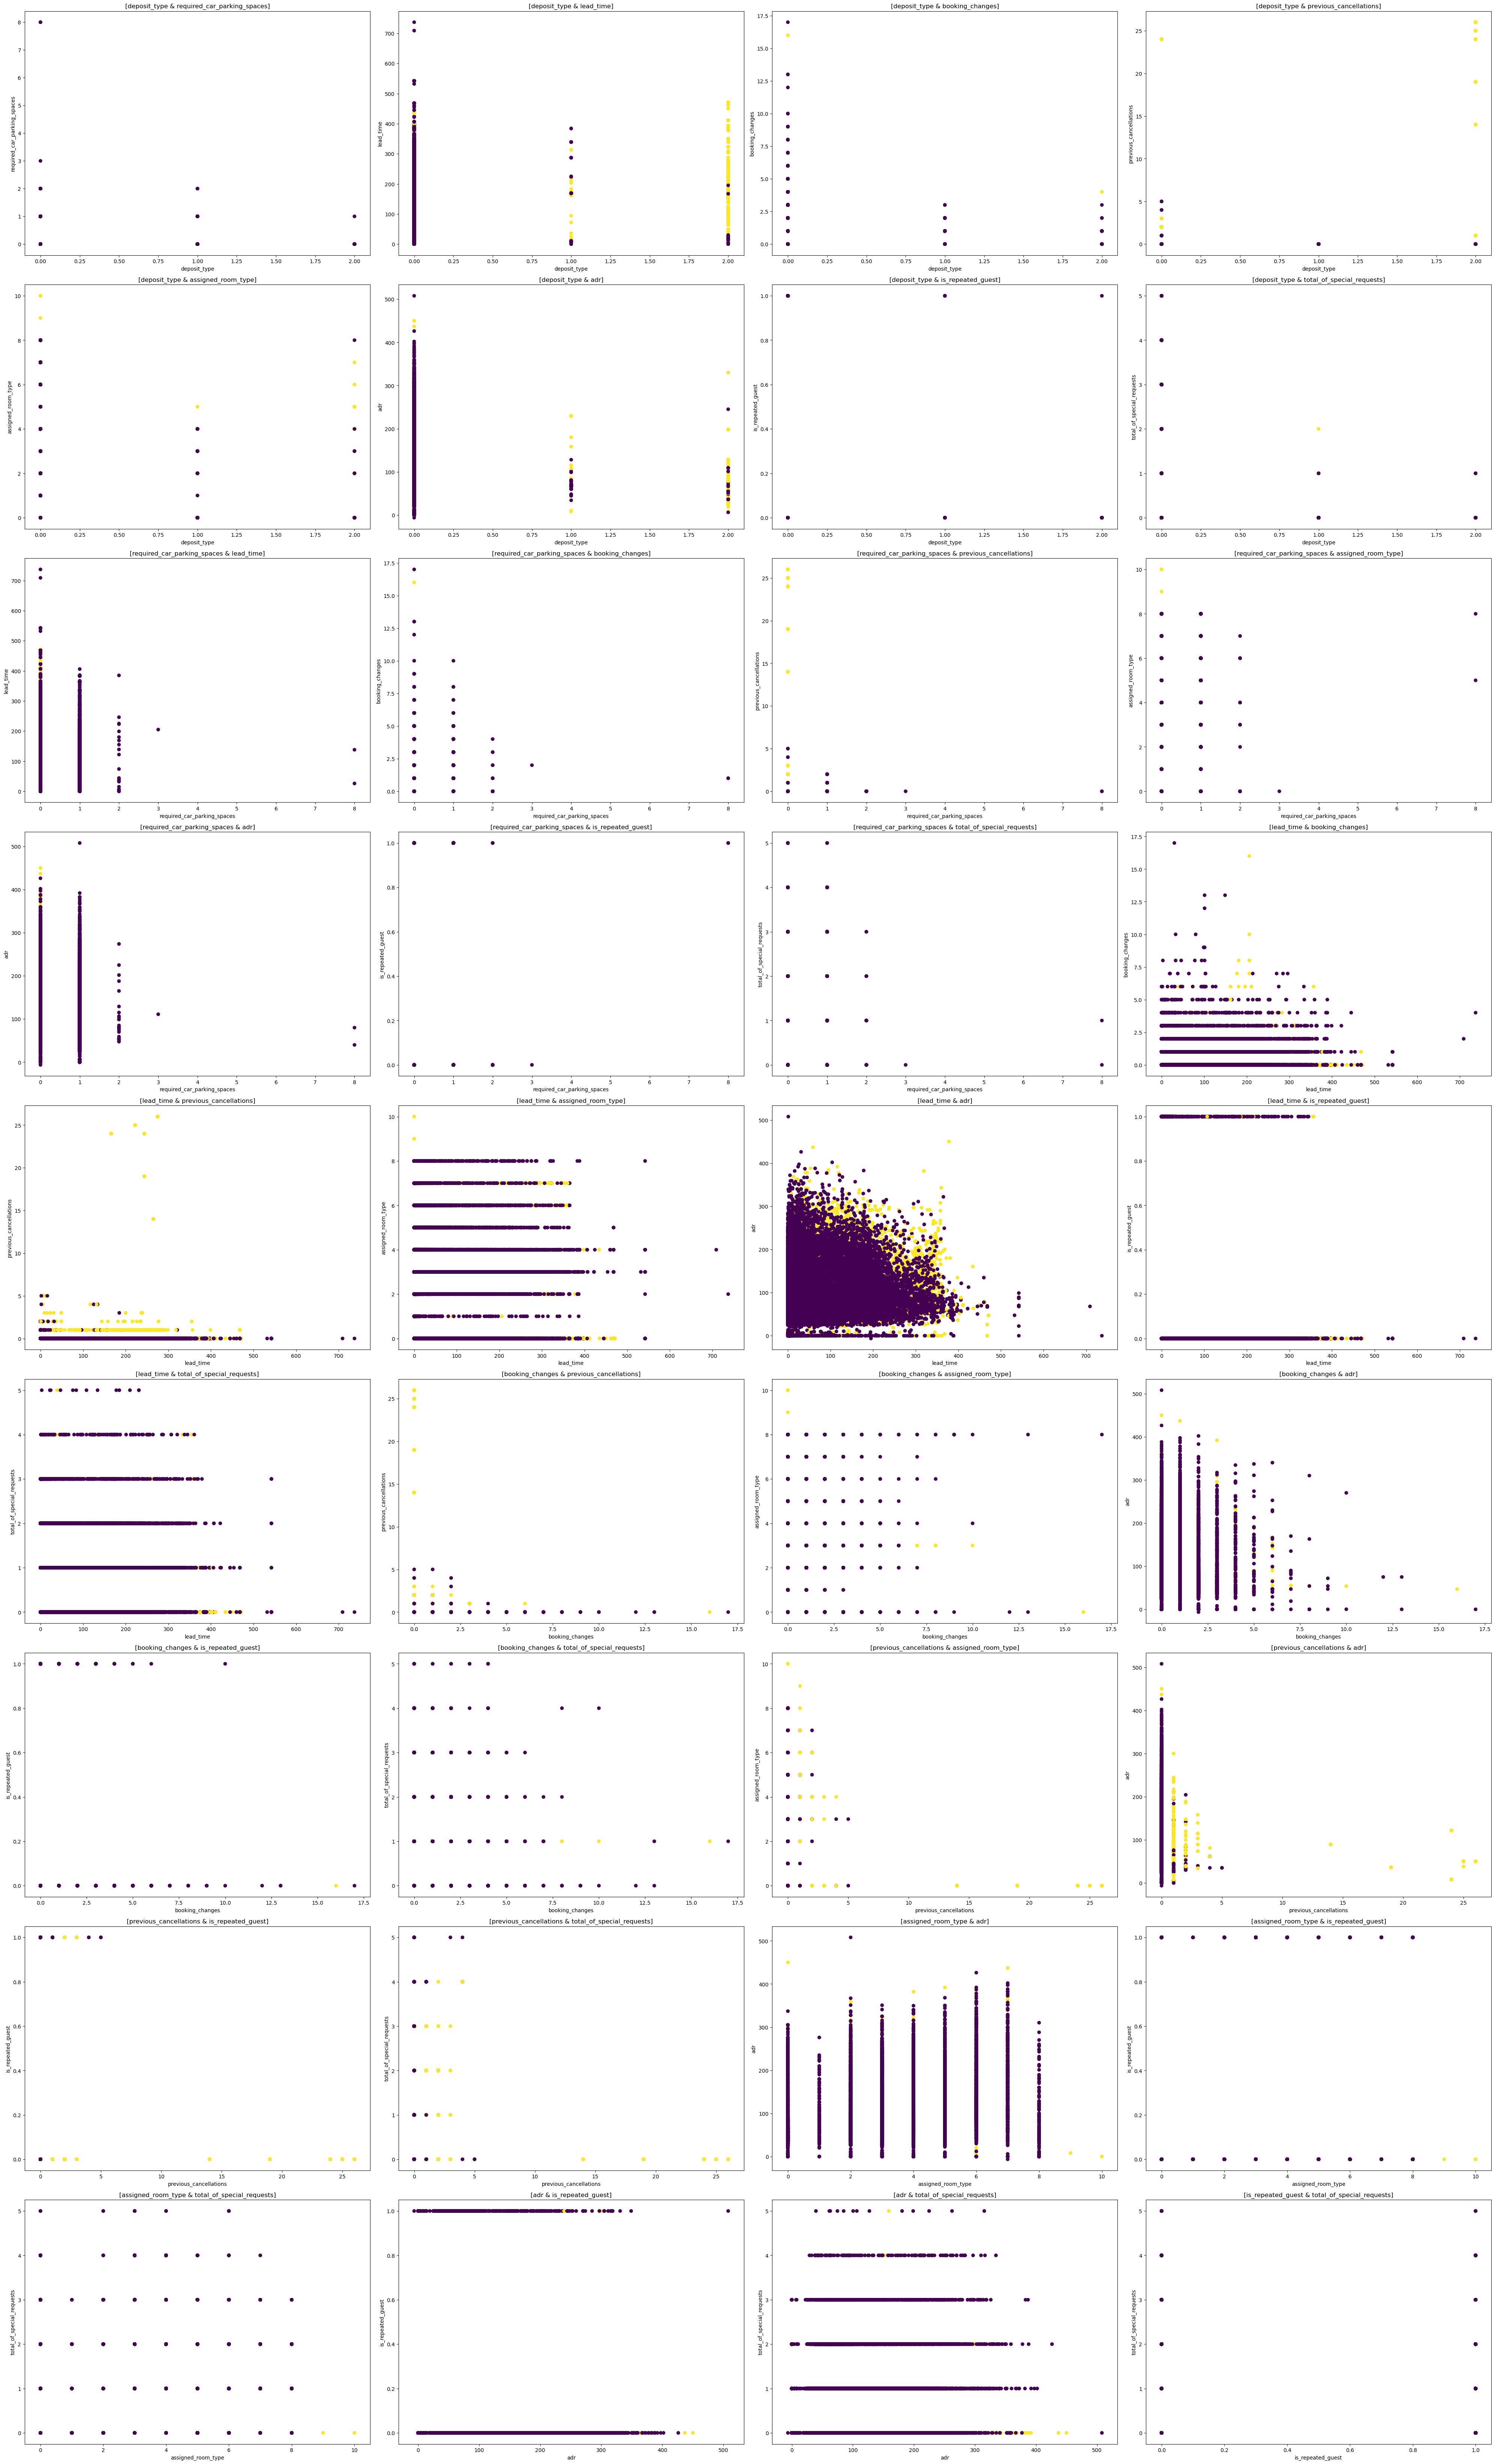

In [12]:
# 피처 - 피처 scatter 그래프 그리기
from itertools import combinations

#col = ['deposit_type', 'required_car_parking_spaces', 'lead_time', 'booking_changes', 'previous_cancellations'] 
col= ['deposit_type', 'required_car_parking_spaces', 'lead_time', 'booking_changes', 'previous_cancellations', 'assigned_room_type', 'adr', 'is_repeated_guest', 'total_of_special_requests']

# print('가능한 경우의 수 : ', len(list(combinations(col, 2))))

n = 1
plt.figure(figsize=(40, 80))
for i, v in combinations(col, 2) : 
    #print(i, v) >> 출력값 확인 용도
    plt.subplot(11, 4, n)
    plt.title(f'[{i} & {v}]')
    plt.scatter(rtDF[i], rtDF[v], c = rtDF['is_canceled'])
    plt.xlabel(i)
    plt.ylabel(v)
    n+=1
    if n>len(list(combinations(col, 2))) :
        break

plt.tight_layout()  # subplot 간의 간격 조정
plt.show()

In [ ]:
import seaborn as sns

sns.heatmap(rtDF[col].corr(numeric_only=True))

In [13]:
# 피처 - 타겟 분리
featureDF = rtDF[col]
targetSR = rtDF['is_canceled']


# 훈련용 - 테스트 분리.
from sklearn.model_selection import train_test_split

Xtrn, Xtst, ytrn, ytst = train_test_split(featureDF, targetSR, test_size=0.2, stratify=targetSR, random_state = 5)

In [14]:
# 분리한 데이터 확인
print(f'Xtrain = {Xtrn.shape}, Xtest = {Xtst.shape}')
print(f'ytrain = {ytrn.shape}, ytest = {ytst.shape}')

Xtrain = (32048, 9), Xtest = (8012, 9)
ytrain = (32048,), ytest = (8012,)


In [15]:
# 스케일링.
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

stdMdl = StandardScaler()
stdMdl.fit(Xtrn)
stdMdl_Xtrn = stdMdl.transform(Xtrn)
stdMdl_Xtst = stdMdl.transform(Xtst)

mmMdl = MinMaxScaler()
mmMdl.fit(Xtrn)
mmMdl_Xtrn = mmMdl.transform(Xtrn)
mmMdl_Xtst = mmMdl.transform(Xtst)

rbMdl = RobustScaler()
rbMdl.fit(Xtrn)
rbMdl_Xtrn = rbMdl.transform(Xtrn)
rbMdl_Xtst = rbMdl.transform(Xtst)

In [16]:
print(f'[Standard Scaler] Xtrain : {stdMdl_Xtrn.shape}, Xtest : {stdMdl_Xtst.shape}')
print(f'[MinMax Scaler] Xtrain : {mmMdl_Xtrn.shape}, Xtest : {mmMdl_Xtst.shape}')
print(f'[Robust Scaler] Xtrain : {rbMdl_Xtrn.shape}, Xtest : {rbMdl_Xtst.shape}')

[Standard Scaler] Xtrain : (32048, 9), Xtest : (8012, 9)
[MinMax Scaler] Xtrain : (32048, 9), Xtest : (8012, 9)
[Robust Scaler] Xtrain : (32048, 9), Xtest : (8012, 9)


In [17]:
from sklearn.neighbors import KNeighborsClassifier
std_trainScore =[]
std_testScore = []

for k in range(1, 50) :
    kMdl = KNeighborsClassifier(n_neighbors=k)
    kMdl.fit(stdMdl_Xtrn, ytrn)
    kMdl.score(stdMdl_Xtst, ytst)
    std_trainScore.append(kMdl.score(stdMdl_Xtrn, ytrn))
    std_testScore.append(kMdl.score(stdMdl_Xtst, ytst))
print(f'Train Score : {std_trainScore}')
print(f'Test Score : {std_testScore}')

Train Score : [0.9805292061907139, 0.896280579131303, 0.8873876684972541, 0.8620506739890165, 0.8586183225162256, 0.8476972041937094, 0.8460122316525213, 0.8376809785322017, 0.8364328507239142, 0.8315963554667998, 0.8307226660009985, 0.8286944583125312, 0.8279143784323515, 0.8264166250624064, 0.8251372940589117, 0.8238579630554169, 0.8227034448327508, 0.8211120818771842, 0.8201135796305542, 0.8178981527708438, 0.8174301048427359, 0.8162443834248627, 0.8159323514727909, 0.8143097853220169, 0.8138729405891163, 0.8120007488766849, 0.8123127808287569, 0.8109398402396405, 0.8110646530204693, 0.8100973539690465, 0.8088492261607588, 0.8080067398901648, 0.8087556165751373, 0.8070394408387419, 0.8081939590614079, 0.8069458312531204, 0.8079755366949576, 0.8066650024962556, 0.8076323015476785, 0.8063841737393909, 0.8067586120818772, 0.8056040938592112, 0.8048864203694458, 0.8040439340988518, 0.8039815277084373, 0.8029830254618073, 0.8031390414378432, 0.8035446829755367, 0.8022341487768347]
Test S